In [101]:
import numpy as np
import matplotlib.pyplot as plt
from methods import Compute_B, Compute_Vpar_Vperp
from scipy.constants import c, m_e, m_p
import scipy
import pandas as pd

In [102]:
# constants
Re = 6378137
B0 = 3.07e-5                        
B0_Re3 = B0 * (Re**3)               
c2 = c**2    

In [103]:
species = 'electron'
if species == 'proton':
    m = m_p
elif species == 'electron':
    m = m_e
energy = 1.0e+07
pitch_angle = 15
dt_boris = 1.0e-04
dt_rk4 = 1.0e-07

RK4_file = f"Lorentz/{species}/pitch_angle/{species}_trajectory_{energy:.1e}_{pitch_angle}_dt{dt_rk4:.1e}_RK4.csv"
Boris_file = f"Lorentz/{species}/pitch_angle/{species}_trajectory_{energy:.1e}_{pitch_angle}_dt{dt_boris:.1e}_Boris.csv"

RK4 = pd.read_csv(RK4_file)
Boris = pd.read_csv(Boris_file)

In [104]:
RK4["Bx"], RK4["By"], RK4["Bz"] = Compute_B(RK4["x"], RK4["y"], RK4["z"])
Boris["Bx"], Boris["By"], Boris["Bz"] = Compute_B(Boris["x"], Boris["y"], Boris["z"])

In [105]:
RK4["vpar"], RK4["vperp"] = Compute_Vpar_Vperp(RK4["vx"], RK4["vy"], RK4["vz"], RK4["Bx"], RK4["By"], RK4["Bz"])
Boris["vpar"], Boris["vperp"] = Compute_Vpar_Vperp(Boris["vx"], Boris["vy"], Boris["vz"], Boris["Bx"], Boris["By"], Boris["Bz"])

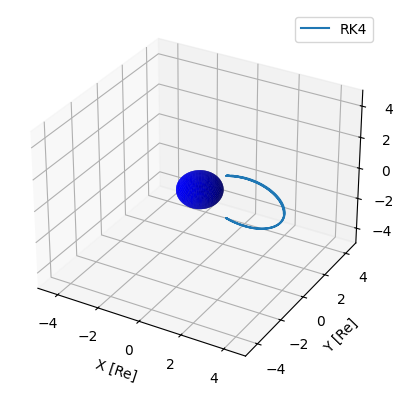

In [106]:
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(RK4["x"]/Re, RK4["y"]/Re, RK4["z"]/Re, label='RK4')
# ax.plot(Boris["x"]/Re, Boris["y"]/Re, Boris["z"]/Re, label='Boris')
ax.set_xlabel('X [Re]')
ax.set_ylabel('Y [Re]')
ax.set_zlabel('Z [Re]')
# add Earth
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b')

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-5, 5])
ax.legend()
plt.show()

In [107]:
# 1st Invariant mu
RK4["v"] = np.sqrt(RK4["vx"]**2 + RK4["vy"]**2 + RK4["vz"]**2)
RK4["B"] = np.sqrt(RK4["Bx"]**2 + RK4["By"]**2 + RK4["Bz"]**2)
RK4["gamma"] = 1/np.sqrt(1 - (RK4["v"]**2/c2))

RK4["mu"] = RK4["gamma"] * m * RK4["vperp"]**2 / (2 * RK4["B"])

Boris["v"] = np.sqrt(Boris["vx"]**2 + Boris["vy"]**2 + Boris["vz"]**2)
Boris["B"] = np.sqrt(Boris["Bx"]**2 + Boris["By"]**2 + Boris["Bz"]**2)
Boris["gamma"] = 1/np.sqrt(1 - (Boris["v"]**2/c2))

Boris["mu"] = Boris["gamma"] * m * Boris["vperp"]**2 / (2 * Boris["B"])

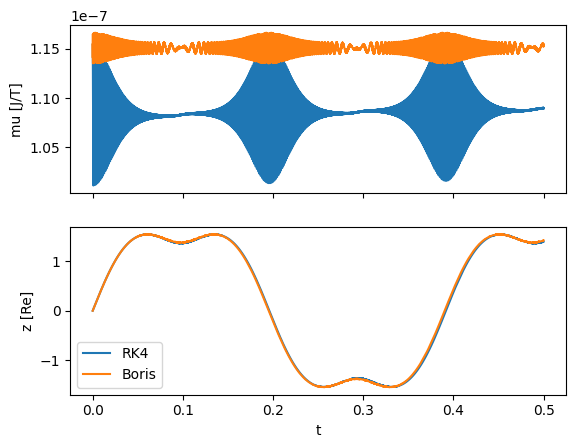

In [129]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(RK4["t"], RK4["mu"][:], label = "RK4")
ax[0].plot(Boris["t"][:int(Boris["t"].size/2)], Boris["mu"][:int(Boris["t"].size/2)], label = "Boris") 
ax[0].set_ylabel("mu [J/T]")
ax[1].plot(RK4["t"], RK4["z"][:]/Re, label = "RK4")
ax[1].plot(Boris["t"][:int(Boris["t"].size/2)], Boris["z"][:int(Boris["t"].size/2)]/Re, label = "Boris")
ax[1].set_ylabel("z [Re]")
ax[1].set_xlabel("t")
plt.legend()
plt.show()
# plt.ylim(0, 4e-6)

In [192]:
# determine the time when the particle reaches the equator
RK4_turning_point = np.where(np.sign(RK4["z"]) != np.sign(RK4["z"].shift(-1)))[0]

# compute the time integral of v_par from 0 to the turning point
RK4_integral_1 = scipy.integrate.trapezoid(((RK4["vpar"][:RK4_turning_point[1]])**2)/RK4["v"][:RK4_turning_point[1]], RK4["t"][:RK4_turning_point[1]])
RK4_integral_2 = scipy.integrate.trapezoid(((RK4["vpar"][RK4_turning_point[1]:RK4_turning_point[2]])**2)/RK4["v"][RK4_turning_point[1]:RK4_turning_point[2]], RK4["t"][RK4_turning_point[1]:RK4_turning_point[2]])

print(f"RK4 integral 1: {RK4_integral_1}")
print(f"RK4 integral 2: {RK4_integral_2}")


RK4 integral 1: 39161616.4085501
RK4 integral 2: 39161612.36227484


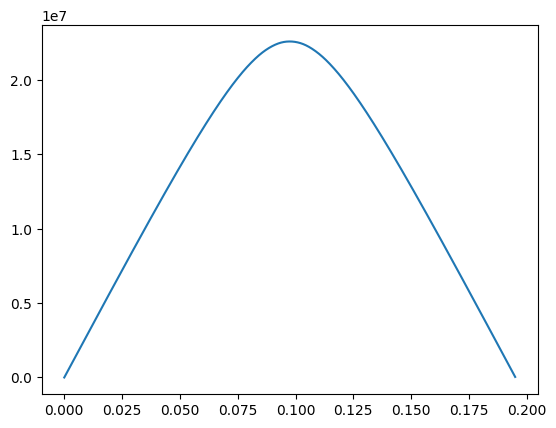

In [178]:
Boris_turning_point = np.where(np.sign(Boris["z"]) != np.sign(Boris["z"].shift(-1)))[0][1]
Boris_integral = scipy.integrate.cumulative_trapezoid(Boris["vpar"][:Boris_turning_point], Boris["t"][:Boris_turning_point], initial=0)
plt.plot(Boris["t"][:Boris_turning_point], Boris_integral)
plt.show()